In [22]:
# --- Librerías ---
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Functions

In [23]:
def normalize_disposition(row):
    val = str(row).upper()
    if val in ['CONFIRMED', 'CP', 'KP']:
        return 'CONFIRMED'
    elif val in ['CANDIDATE', 'PC', 'APC']:
        return 'CANDIDATE'
    elif val in ['FALSE POSITIVE', 'FP', 'FA', 'REFUTED']:
        return 'FALSE'
    else:
        return 'UNKNOWN'

# Input

In [24]:
# --- Cargar tus tres catálogos ---
tess = pd.read_csv("../../data/raw/TESS_TOI_2025.10.04_12.41.47.csv")
kepler = pd.read_csv("../../data/raw/Kepler_cumulative_2025.10.04_12.41.25.csv")
k2 = pd.read_csv("../../data/raw/k2pandc_2025.10.04_12.42.17.csv")

## Data Prep

In [25]:
tess.rename(columns={
    'tfopwg_disp': 'disposition_raw',              # estado (CP, FP, PC, APC, FA, KP)
    'ra': 'ra',                           # ascensión recta
    'dec': 'dec',                         # declinación
    'pl_orbper': 'pl_orbper',             # periodo orbital
    'pl_rade': 'pl_rade',                 # radio planetario
    'pl_insol': 'pl_insol',               # flujo de insolación
    'pl_eqt': 'pl_eqt',                   # temperatura de equilibrio
    'st_teff': 'st_teff',                 # temperatura efectiva estelar
    'st_logg': 'st_logg',                 # gravedad superficial estelar
    'st_rad': 'st_rad',                   # radio estelar
    'st_tmag': 'st_tmag',                 # magnitud óptica (TESS mag)
    'rowupdate': 'rowupdate'              # fecha de actualización
}, inplace=True)
tess['mission'] = 'TESS'

tess_reduced_df = tess[['disposition_raw', 'ra', 'dec', 'pl_orbper', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_logg', 'st_rad', 'st_tmag', 'mission']]

In [26]:
kepler.rename(columns={
    'koi_disposition': 'disposition_raw',          # CONFIRMED, CANDIDATE, FALSE POSITIVE
    'ra': 'ra',
    'dec': 'dec',
    'koi_period': 'pl_orbper',            # periodo orbital
    'koi_prad': 'pl_rade',                # radio planetario
    'koi_insol': 'pl_insol',              # flujo de insolación
    'koi_teq': 'pl_eqt',                  # temperatura de equilibrio
    'koi_steff': 'st_teff',               # temperatura efectiva estelar
    'koi_slogg': 'st_logg',               # gravedad superficial estelar
    'koi_srad': 'st_rad',                 # radio estelar
    'koi_kepmag': 'st_tmag'               # magnitud óptica (Kepler mag)
}, inplace=True)

kepler['mission'] = 'Kepler'

kepler_reduced_df = kepler[['disposition_raw', 'ra', 'dec', 'pl_orbper', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_logg', 'st_rad', 'st_tmag', 'mission']]

In [27]:
k2.rename(columns={
    'disposition': 'disposition_raw',          # CONFIRMED, CANDIDATE, FALSE POSITIVE
    'ra': 'ra',
    'dec': 'dec',
    'pl_orbper': 'pl_orbper',             # periodo orbital
    'pl_rade': 'pl_rade',                 # radio planetario
    'pl_insol': 'pl_insol',               # flujo de insolación
    'pl_eqt': 'pl_eqt',                   # temperatura de equilibrio
    'st_teff': 'st_teff',                 # temperatura efectiva estelar
    'st_logg': 'st_logg',                 # gravedad superficial estelar
    'st_rad': 'st_rad',                   # radio estelar
    'sy_vmag': 'st_tmag',                 # magnitud óptica (K2)
}, inplace=True)

k2['mission'] = 'K2'

k2_reduced_df = k2[['disposition_raw', 'ra', 'dec', 'pl_orbper', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_logg', 'st_rad', 'st_tmag', 'mission']]

In [28]:
combined = pd.concat([tess_reduced_df, kepler_reduced_df, k2_reduced_df], ignore_index=True)

In [29]:
combined['disposition_norm'] = combined['disposition_raw'].apply(normalize_disposition)

In [30]:
cleaned_df = combined.dropna()

In [31]:
cleaned_df.isna().sum()

disposition_raw     0
ra                  0
dec                 0
pl_orbper           0
pl_rade             0
pl_insol            0
pl_eqt              0
st_teff             0
st_logg             0
st_rad              0
st_tmag             0
mission             0
disposition_norm    0
dtype: int64

In [32]:
cleaned_df.drop(columns=['disposition_raw', 'pl_orbper'], inplace=True)

C:\Users\anala\AppData\Local\Temp\ipykernel_20284\4262551033.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=['disposition_raw', 'pl_orbper'], inplace=True)


In [33]:
encoded_df = cleaned_df.copy()
label_encoders = {}
encoding_maps = {}

for col in encoded_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    label_encoders[col] = le
    encoding_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [34]:
encoding_maps

{'mission': {'K2': 0, 'Kepler': 1, 'TESS': 2},
 'disposition_norm': {'CANDIDATE': 0, 'CONFIRMED': 1, 'FALSE': 2}}

In [35]:
data = encoded_df.copy()

# Guardamos las clases de la variable objetivo (corregido: verificar si fue codificado)
if 'disposition_norm' in label_encoders:
    disposition_norm_classes = label_encoders['disposition_norm'].classes_
    
else:
    # En caso de que ya sea numérico, creamos etiquetas genéricas
    disposition_norm_classes = [str(cls) for cls in sorted(data['disposition_norm'].unique())]

# Main

## Definir Target

In [36]:
X = data.drop('disposition_norm', axis=1)
y = data['disposition_norm']

In [37]:
# --- Normalizar las variables numéricas ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
# --- Dividir datos para entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Modelos Simples

🔹 Regresión Logística
   Exactitud: 0.5976
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.67      0.70      0.68      1251
   CONFIRMED       0.51      0.36      0.42       878
       FALSE       0.57      0.67      0.61      1104

    accuracy                           0.60      3233
   macro avg       0.58      0.58      0.57      3233
weighted avg       0.59      0.60      0.59      3233



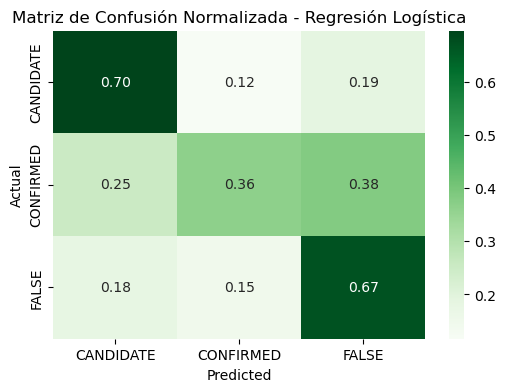

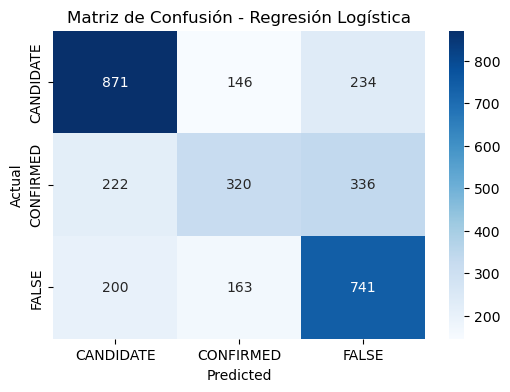

--------------------------------------------------
🔹 Bosque Aleatorio
   Exactitud: 0.7343
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.70      0.76      0.73      1251
   CONFIRMED       0.72      0.70      0.71       878
       FALSE       0.79      0.73      0.76      1104

    accuracy                           0.73      3233
   macro avg       0.74      0.73      0.73      3233
weighted avg       0.74      0.73      0.73      3233



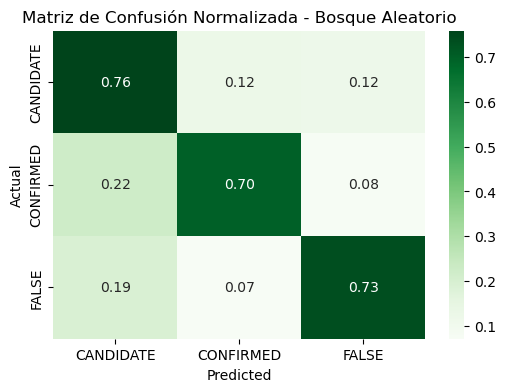

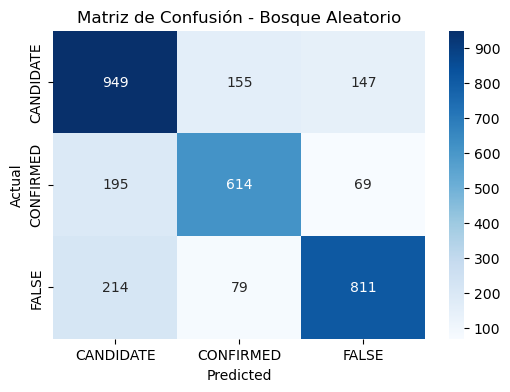

--------------------------------------------------
🔹 SVM
   Exactitud: 0.6486
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.68      0.69      0.69      1251
   CONFIRMED       0.58      0.51      0.54       878
       FALSE       0.66      0.71      0.68      1104

    accuracy                           0.65      3233
   macro avg       0.64      0.64      0.64      3233
weighted avg       0.65      0.65      0.65      3233



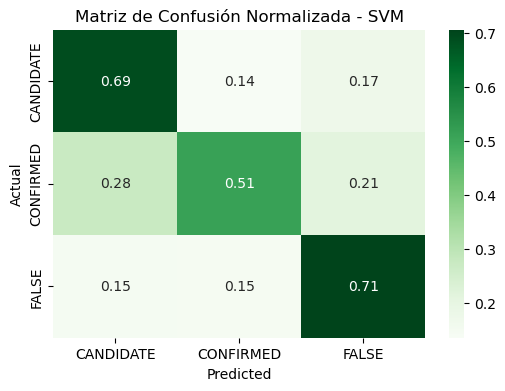

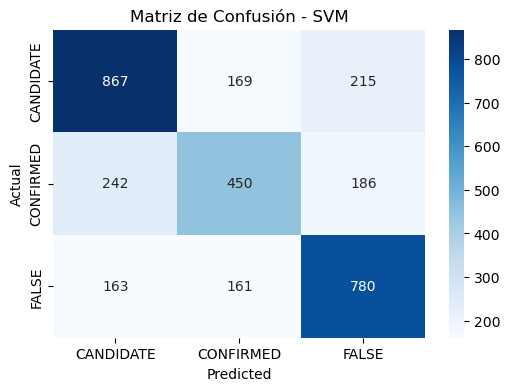

--------------------------------------------------
🔹 KNN
   Exactitud: 0.6202
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.62      0.69      0.65      1251
   CONFIRMED       0.54      0.56      0.55       878
       FALSE       0.70      0.59      0.64      1104

    accuracy                           0.62      3233
   macro avg       0.62      0.61      0.61      3233
weighted avg       0.63      0.62      0.62      3233



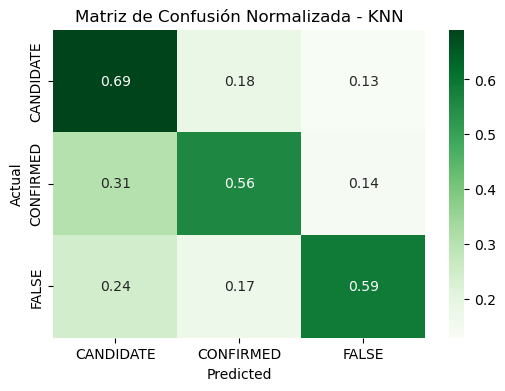

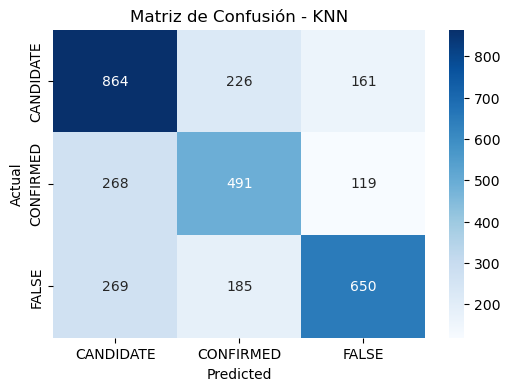

--------------------------------------------------


In [39]:
# --- 5️⃣ Definir modelos a comparar ---
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Bosque Aleatorio": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

# --- 6️⃣ Entrenar y evaluar ---
n_classes = len(disposition_norm_classes)
class_labels = list(range(n_classes))  # Etiquetas numéricas: [0, 1, ..., n-1]

le_status = label_encoders['disposition_norm']
disposition_norm_classes = le_status.classes_
class_labels = list(range(len(disposition_norm_classes)))  # [0, 1, ..., n-1]

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    
    print(f"🔹 {name}")
    print(f"   Exactitud: {acc:.4f}")
    
    # Corregido: Especificar labels para manejar clases faltantes en test
    report = classification_report(y_test, preds, target_names=disposition_norm_classes, 
                                   labels=class_labels, zero_division=0)
    print(f"   Reporte:\n{report}")

    # Corregido: Especificar labels para matriz de confusión completa
    cm = confusion_matrix(y_test, preds, labels=class_labels)
    # Matriz normalizada (%)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)  # Evitar división por cero
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=disposition_norm_classes, yticklabels=disposition_norm_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión Normalizada - {name}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=disposition_norm_classes, yticklabels=disposition_norm_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()
    print("-" * 50)

In [40]:
disposition_norm_classes

array(['CANDIDATE', 'CONFIRMED', 'FALSE'], dtype=object)

## Modelos de RN

🔹 MLP Simple (1 capa: 100 neuronas)
   Exactitud: 0.6879
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.70      0.65      0.68      1251
   CONFIRMED       0.61      0.67      0.64       878
       FALSE       0.73      0.74      0.74      1104

    accuracy                           0.69      3233
   macro avg       0.68      0.69      0.69      3233
weighted avg       0.69      0.69      0.69      3233



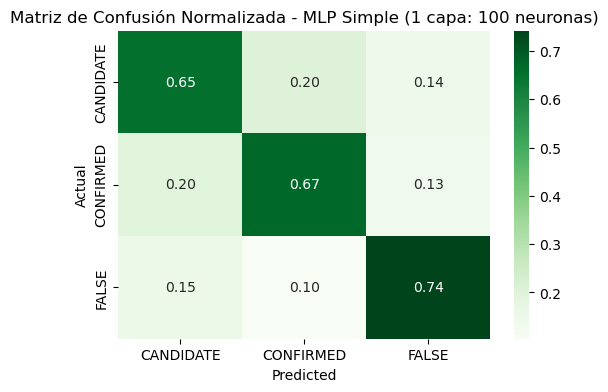

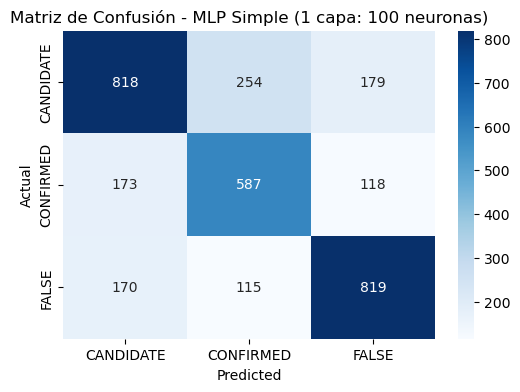

--------------------------------------------------
🔹 MLP (2 capas: 50-50)
   Exactitud: 0.6922
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.70      0.67      0.69      1251
   CONFIRMED       0.61      0.67      0.64       878
       FALSE       0.76      0.73      0.75      1104

    accuracy                           0.69      3233
   macro avg       0.69      0.69      0.69      3233
weighted avg       0.70      0.69      0.69      3233



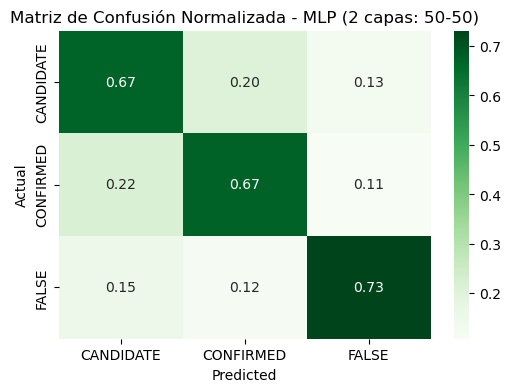

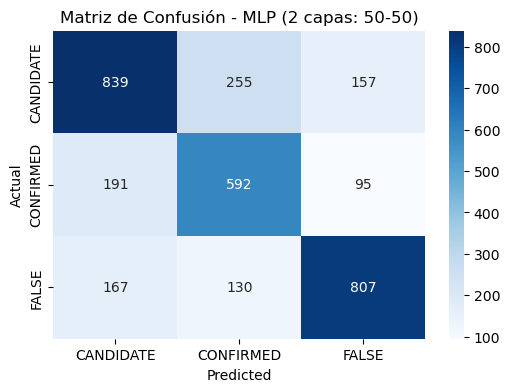

--------------------------------------------------
🔹 MLP (2 capas: 100-50)
   Exactitud: 0.6867
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.69      0.67      0.68      1251
   CONFIRMED       0.63      0.63      0.63       878
       FALSE       0.73      0.75      0.74      1104

    accuracy                           0.69      3233
   macro avg       0.68      0.68      0.68      3233
weighted avg       0.69      0.69      0.69      3233



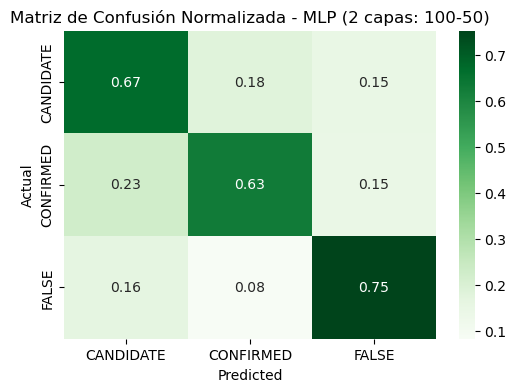

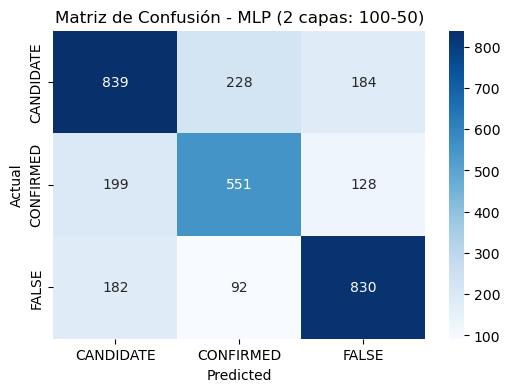

--------------------------------------------------
🔹 MLP con tanh (100)
   Exactitud: 0.6796
   Reporte:
              precision    recall  f1-score   support

   CANDIDATE       0.69      0.65      0.67      1251
   CONFIRMED       0.59      0.67      0.63       878
       FALSE       0.74      0.72      0.73      1104

    accuracy                           0.68      3233
   macro avg       0.68      0.68      0.68      3233
weighted avg       0.68      0.68      0.68      3233



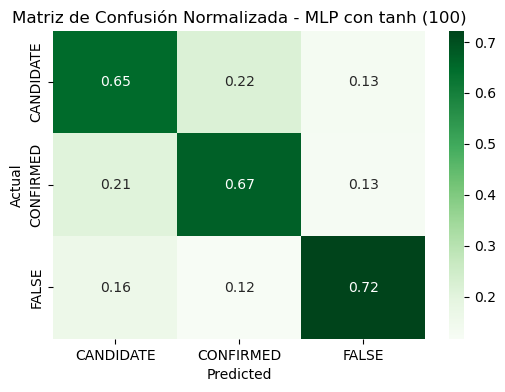

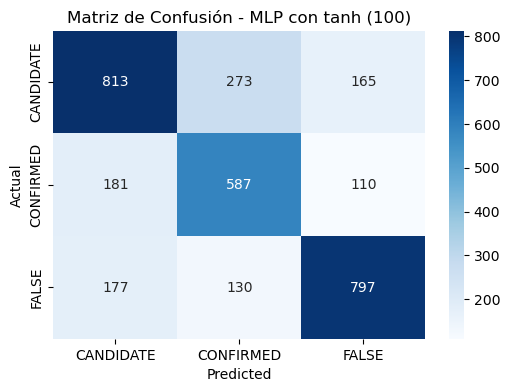

--------------------------------------------------


In [41]:
# --- 5️⃣ Definir modelos de redes neuronales a comparar ---
# Usamos MLPClassifier de scikit-learn para mantener consistencia con el flujo sklearn
# Variantes con diferentes arquitecturas de capas ocultas
from sklearn.neural_network import MLPClassifier

models = {
    "MLP Simple (1 capa: 100 neuronas)": MLPClassifier(hidden_layer_sizes=(100,), 
                                                       activation='relu', 
                                                       solver='adam', 
                                                       max_iter=1000, 
                                                       random_state=42),
    "MLP (2 capas: 50-50)": MLPClassifier(hidden_layer_sizes=(50, 50), 
                                          activation='relu', 
                                          solver='adam', 
                                          max_iter=1000, 
                                          random_state=42),
    "MLP (2 capas: 100-50)": MLPClassifier(hidden_layer_sizes=(100, 50), 
                                           activation='relu', 
                                           solver='adam', 
                                           max_iter=1000, 
                                           random_state=42),
    "MLP con tanh (100)": MLPClassifier(hidden_layer_sizes=(100,), 
                                        activation='tanh', 
                                        solver='adam', 
                                        max_iter=1000, 
                                        random_state=42)
}

# --- 6️⃣ Entrenar y evaluar ---
n_classes = len(disposition_norm_classes)
class_labels = list(range(n_classes))  # Etiquetas numéricas: [0, 1, ..., n-1]

le_status = label_encoders['disposition_norm']
disposition_norm_classes = le_status.classes_
class_labels = list(range(len(disposition_norm_classes)))  # [0, 1, ..., n-1]

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    
    print(f"🔹 {name}")
    print(f"   Exactitud: {acc:.4f}")
    
    # Corregido: Especificar labels para manejar clases faltantes en test
    report = classification_report(y_test, preds, target_names=disposition_norm_classes, 
                                   labels=class_labels, zero_division=0)
    print(f"   Reporte:\n{report}")

    # Corregido: Especificar labels para matriz de confusión completa
    cm = confusion_matrix(y_test, preds, labels=class_labels)
    # Matriz normalizada (%)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)  # Evitar división por cero
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=disposition_norm_classes, yticklabels=disposition_norm_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión Normalizada - {name}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=disposition_norm_classes, yticklabels=disposition_norm_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()
    print("-" * 50)